In [1]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
# tr.set_default_dtype(tr.float)
# tr.set_default_device(device)

In [3]:
# # theta = tr.tensor([tr.pi/4+0.1,tr.pi/2+0.1,3/2*tr.pi+0.1])
# # theta = tr.round(theta*2/tr.pi)*tr.pi/2
# # print(theta)
# a = tr.tensor([i*tr.pi/2 for i in range(-2,6)]) 
# print(a*2/tr.pi)

# theta = ((tr.round(a*2/tr.pi))%4)*tr.pi/2
# print(theta)

In [4]:
#hyperparameters
runs = 1
batch_size = 1024
epoch = 400
t_update = 10
g = 0.8
max_steps = 400

target = [0.5,0]
deviation = 0.05
target_area = [[target[0]-deviation,target[0]+deviation],
               [target[1]-deviation,target[1]+deviation]]
U0 = 0.4
lstm_hidden_size = 0#8
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.dpi': 250})

char_size = 3
dt = 0.03#75

In [5]:
def d(L):
    direction_mapping = [
        
        tr.tensor(0,dtype=tr.float).to(device),
        # tr.tensor(1/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi/2,dtype=tr.float).to(device), 
        # tr.tensor(3/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi,dtype=tr.float).to(device), 
        # tr.tensor(5/4*tr.pi,dtype=tr.float).to(device),
        tr.tensor(3/2 * tr.pi,dtype=tr.float).to(device),
        # tr.tensor(7/4 * tr.pi,dtype=tr.float).to(device)
    ]
    return tr.stack(direction_mapping).to(device)[L]

def U(U0,x,y):
    bool = (x**2+y**2)**0.5>0.5
    P = 16*U0*(x**2+y**2-0.25)**2
    P[bool] = 0
    return P
    
def force(x,y,type='mexican'):
    if type == 'lorenzian':
        if isinstance(x, tr.Tensor):
            F_x = tr.zeros(y.shape).to(device)
            F_y = U0/(1+6*x**2)
            return F_x, F_y
        else:
            U,V = np.zeros(y.shape), U0/(1+6*x**2)
            return U,V
    if type == 'mexican':
        if isinstance(x, tr.Tensor):
            r = tr.sqrt(x**2+y**2)
            bool = r>0.4
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            # f = tr.stack([fr*x,fr*y],dim=1).to(device)
            F_x = fr*x
            F_y = fr*y
            return F_x,F_y
        else:
            r = np.sqrt(x**2+y**2)
            bool = r>0.5
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            U,V = fr*x,fr*y
            #U,V = x*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2)), y*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2))
            return U,V
def plot_potential():
    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.scatter(-0.5,0,c='black',label='start',marker='D')    
    plt.scatter(0.5,0,c='black',label='goal',marker='x')


    X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))

    Potential = U(U0,X1,Y1)/U0
    # _,forcefield = force(X1,Y1)
    plt.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
    colorbar = plt.colorbar()
    colorbar.set_label(r'$U/U_0$',labelpad=10,fontsize = 20)
    colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

In [6]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        
        # self.theta = tr.tensor(0,dtype=tr.float) #orientation
        self.flag = False #Flag to check if an agent has reached target area
        self.winner_index = 0
        #Layers:
        self.layers = nn.Sequential(
            nn.Linear(4+lstm_hidden_size, 32,dtype=tr.float),
            nn.LeakyReLU(),
            nn.Linear(32,32,dtype=tr.float),
            nn.LeakyReLU(),
            nn.Linear(32,4,dtype=tr.float)
        )

    def forward(self, x):
        frwd = self.layers(x)
        return frwd
    
    def init_model(self):
        self.dt = 0

    def move_reward(self,Q,F_x,F_y,epsilon): #Moves the agent (in-place) and returns the reward (out-of-place)

        L=tr.argmax(Q,dim=1).to(device)

        #e-greedy
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        epsilon_bool = random_vector<epsilon
        L[epsilon_bool] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) 

        #thermal noise        
        theta = d(L).to(device)
        noise = tr.normal(tr.zeros(batch_size),tr.ones(batch_size)).to(device)
        theta += np.sqrt(dt)*char_size*noise
        #Transformation back to descrete values
        theta = ((tr.round(theta*2/tr.pi))%4)*tr.pi/2


        wall = 0.75*tr.ones(self.x.shape).to(device)
        e_x = tr.cos(theta)
        v_x = e_x + F_x
        x_new = self.x + v_x*dt
        
        wall_bool_x_left = -wall <= x_new
        wall_bool_x_right =  x_new <= wall
        wall_bool_x = wall_bool_x_left*wall_bool_x_right


        e_y = tr.sin(theta)
        v_y = e_y + F_y
        y_new = self.y + v_y*dt

        wall_bool_y_left = -wall <= y_new
        wall_bool_y_right =  y_new <= wall
        wall_bool_y = wall_bool_y_left*wall_bool_y_right

        wall_bool = wall_bool_x * wall_bool_y #Bool that has True entries if the move stays within the constraints
        
        #movement within constraints
        self.x[wall_bool] = x_new[wall_bool]
        self.y[wall_bool] = y_new[wall_bool]

        #punish for hitting wall
        wall_bool = tr.logical_not(wall_bool)
        reward_t = -tr.ones(self.x.shape,dtype = tr.float).to(device)*dt/100 #r=-dt
        reward_t[wall_bool] = -10 
        
        #Reward getting to the target area!
        target_bool_x_left = target_area[0][0] <= self.x
        target_bool_x_right = self.x <= target_area[0][1]
        target_bool_x = target_bool_x_left*target_bool_x_right
        target_bool_y_left = target_area[1][0] <= self.y
        target_bool_y_right = self.y <= target_area[1][1]
        target_bool_y = target_bool_y_left*target_bool_y_right

        target_bool = target_bool_x*target_bool_y
        reward_t[target_bool] = 100#batch_size #1


        if target_bool.sum()>0: 
            self.flag = True
            self.winner_index = tr.nonzero(target_bool)[0].item()
            # self.mask = tr.logical_not(target_bool)

        self.dt += dt
        return reward_t

In [7]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer,epsilon):
    # global batch_size
    agent.flag = False
    agent.dt = 0
    agent.winner_index = 0
    X,Y = agent.x,agent.y
    Losses = np.array([])
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every t_update steps
            t_agent.load_state_dict(agent.state_dict())

        F_x,F_y = force(agent.x,agent.y)

        state = tr.stack([agent.x, agent.y, 
                        F_x.to(device), F_y.to(device)], dim=1)#,
                        #tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,
                        #tr.zeros(agent.x.shape, dtype = tr.float).to(device)], dim=1) #state ,                         tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,                        tr.zeros(agent.x.shape, dtype = tr.float).to(device)
        Q1 = agent.forward(state)
        R = agent.move_reward(Q1,F_x,F_y,epsilon)

        t_agent.x = agent.x.clone()
        t_agent.y = agent.y.clone()
        t_F_x,t_F_y = force(t_agent.x,t_agent.y)
        state2 = tr.stack([t_agent.x, t_agent.y,
                        t_F_x.to(device), t_F_y.to(device)], dim=1)#,
                       # tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,
                       # tr.zeros(agent.x.shape, dtype = tr.float).to(device)], dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        #target Q value
        target = R + g*maxQ2 
        criterion = nn.MSELoss()
        target.detach()
        loss = criterion(target,maxQ1)
        
        #backpropagate
        loss.backward()
        
        #update weights and detach                         
        optimizer.step()   
        # agent.detach_hc()
        # t_agent.detach_hc()
        
        Losses = np.append(Losses,loss.item())
        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]


        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)
        
        if agent.flag:
            break
            # agent.x = agent.x[agent.mask]
            # agent.y = agent.y[agent.mask]
            
            # batch_size -= 1
            
    Losses = np.array(Losses).mean()
    
    return X,Y, Losses

In [8]:
#Simulation
def simulation():
    x = tr.zeros(batch_size,dtype = tr.float).to(device)-0.5
    y = tr.zeros(batch_size,dtype = tr.float).to(device)
    agent = Agent(x,y).to(device)
    agent.init_model()

    t_agent = Agent(x,y).to(device)
    t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
    t_agent.eval()

    optimizer = tr.optim.Adam(agent.parameters(), lr=0.01)

    interval = epoch//5
    milestones = [interval,interval*2,interval*3,interval*4]
    scheduler = MultiStepLR(optimizer,milestones, gamma = 0.7)

    x_paths = []
    y_paths = []
    Loss_total = []
    success_episodes = []
    travel_time = []
    convergence = True
    # multistep_episodes = np.repeat(np.round(np.linspace(400,75,5),0),epoch//5) 

    for i in range(epoch):

        epsilon = 1-(i/epoch)*0.9
        X,Y,loss_mean = episode(agent, t_agent, t_update, max_steps, g, optimizer,epsilon) #int(multistep_episodes[i])
        if X[agent.winner_index].shape[0] == max_steps + 1:

            # if i > epoch//2:
            #     print('No convergence')
            #     convergence = False
            #     break
            success_episodes.append(0)
        else:
            success_episodes.append(1)

        travel_time.append(X[agent.winner_index].shape[0]*dt)

        if i%(epoch//5) == epoch//5-1:
            print(i)
            x,y = X[agent.winner_index].detach().to('cpu').numpy(),Y[agent.winner_index].detach().to('cpu').numpy()
            x_paths.append(x)
            y_paths.append(y)
            # plt.plot(x,y)

        Loss_total.append(loss_mean)
        agent.x = tr.zeros(batch_size,dtype = tr.float).to(device)-0.5
        agent.y = tr.zeros(batch_size,dtype = tr.float).to(device)
        scheduler.step()
    # plot_potential()
    # if convergence == False: return (0,0,0,0,0)
    return x_paths, y_paths, Loss_total, success_episodes, travel_time


In [9]:
Runs_Loss_total = []
Runs_success_episodes = []
Runs_travel_time = []
episode_plots = np.linspace(epoch//5,epoch,5) 
for i in range(runs):
    X_tot, Y_tot, Loss_total, success_episodes, travel_time = simulation()
    for ep in range(len(X_tot)):
        x = X_tot[ep]
        y = Y_tot[ep]

        if x.shape[0] == max_steps+1: T = r'$\infty$'
        else: T = str(np.round(len(x)*dt,2))
        path_label = 'T(' + str(int(episode_plots[ep])) +') = '+ T

        plt.plot(x,y,label=path_label)
        
    plot_potential()
    plt.title(r'$\sqrt{D_RL/v_0}$ = '+ str(char_size))

    plt.legend(bbox_to_anchor=(1,-0.1),ncol=2)
    plt.show()
    Runs_Loss_total.append(Loss_total)
    Runs_success_episodes.append(success_episodes)
    Runs_travel_time.append(travel_time)

KeyboardInterrupt: 

In [ ]:
Runs_avg_loss = np.mean(Runs_Loss_total,axis=0)
Runs_avg_succ = np.mean(Runs_success_episodes,axis=0)
Runs_avg_time = np.mean(Runs_travel_time, axis=0)

In [ ]:
def save_data(test):
    fname = 'With_Noise_test_'+str(test)+'_runs'+str(runs)+'_char_size_'+ str(char_size) + '_batch_size_' + str(batch_size) + '_U_0_'+str(U0)+'_'

    np.save(fname+'Runs_Loss_total.npy',Runs_Loss_total)
    np.save(fname+'Runs_success_episodes.npy',Runs_success_episodes)
    np.save(fname+'Runs_travel_time.npy',Runs_travel_time)

    np.save(fname+'Runs_avg_loss.npy',Runs_avg_loss)
    np.save(fname+'Runs_avg_succ.npy',Runs_avg_succ)
    np.save(fname+'Runs_avg_time.npy',Runs_avg_time)


# save_data(2)

def load_data(fname):
    Runs_Loss_total = np.load(fname+ 'Runs_Loss_total.npy')
    Runs_success_episodes = np.load(fname+ 'Runs_success_episodes.npy')
    Runs_travel_time = np.load(fname+'Runs_travel_time.npy')

    Runs_avg_loss = np.load(fname+'Runs_avg_loss.npy')
    Runs_avg_succ = np.load(fname+'Runs_avg_succ.npy')
    Runs_avg_time = np.load(fname+'Runs_avg_time.npy')

    return Runs_Loss_total, Runs_success_episodes, Runs_travel_time, Runs_avg_loss, Runs_avg_succ, Runs_avg_time



In [ ]:
# Runs_avg_loss = loaded_tensor

In [ ]:
# np.savetxt('Runs_avg_loss.txt', Runs_avg_loss,delimiter = ',')
# np.savetxt('Runs_avg_succ.txt', Runs_avg_succ,delimiter = ',')

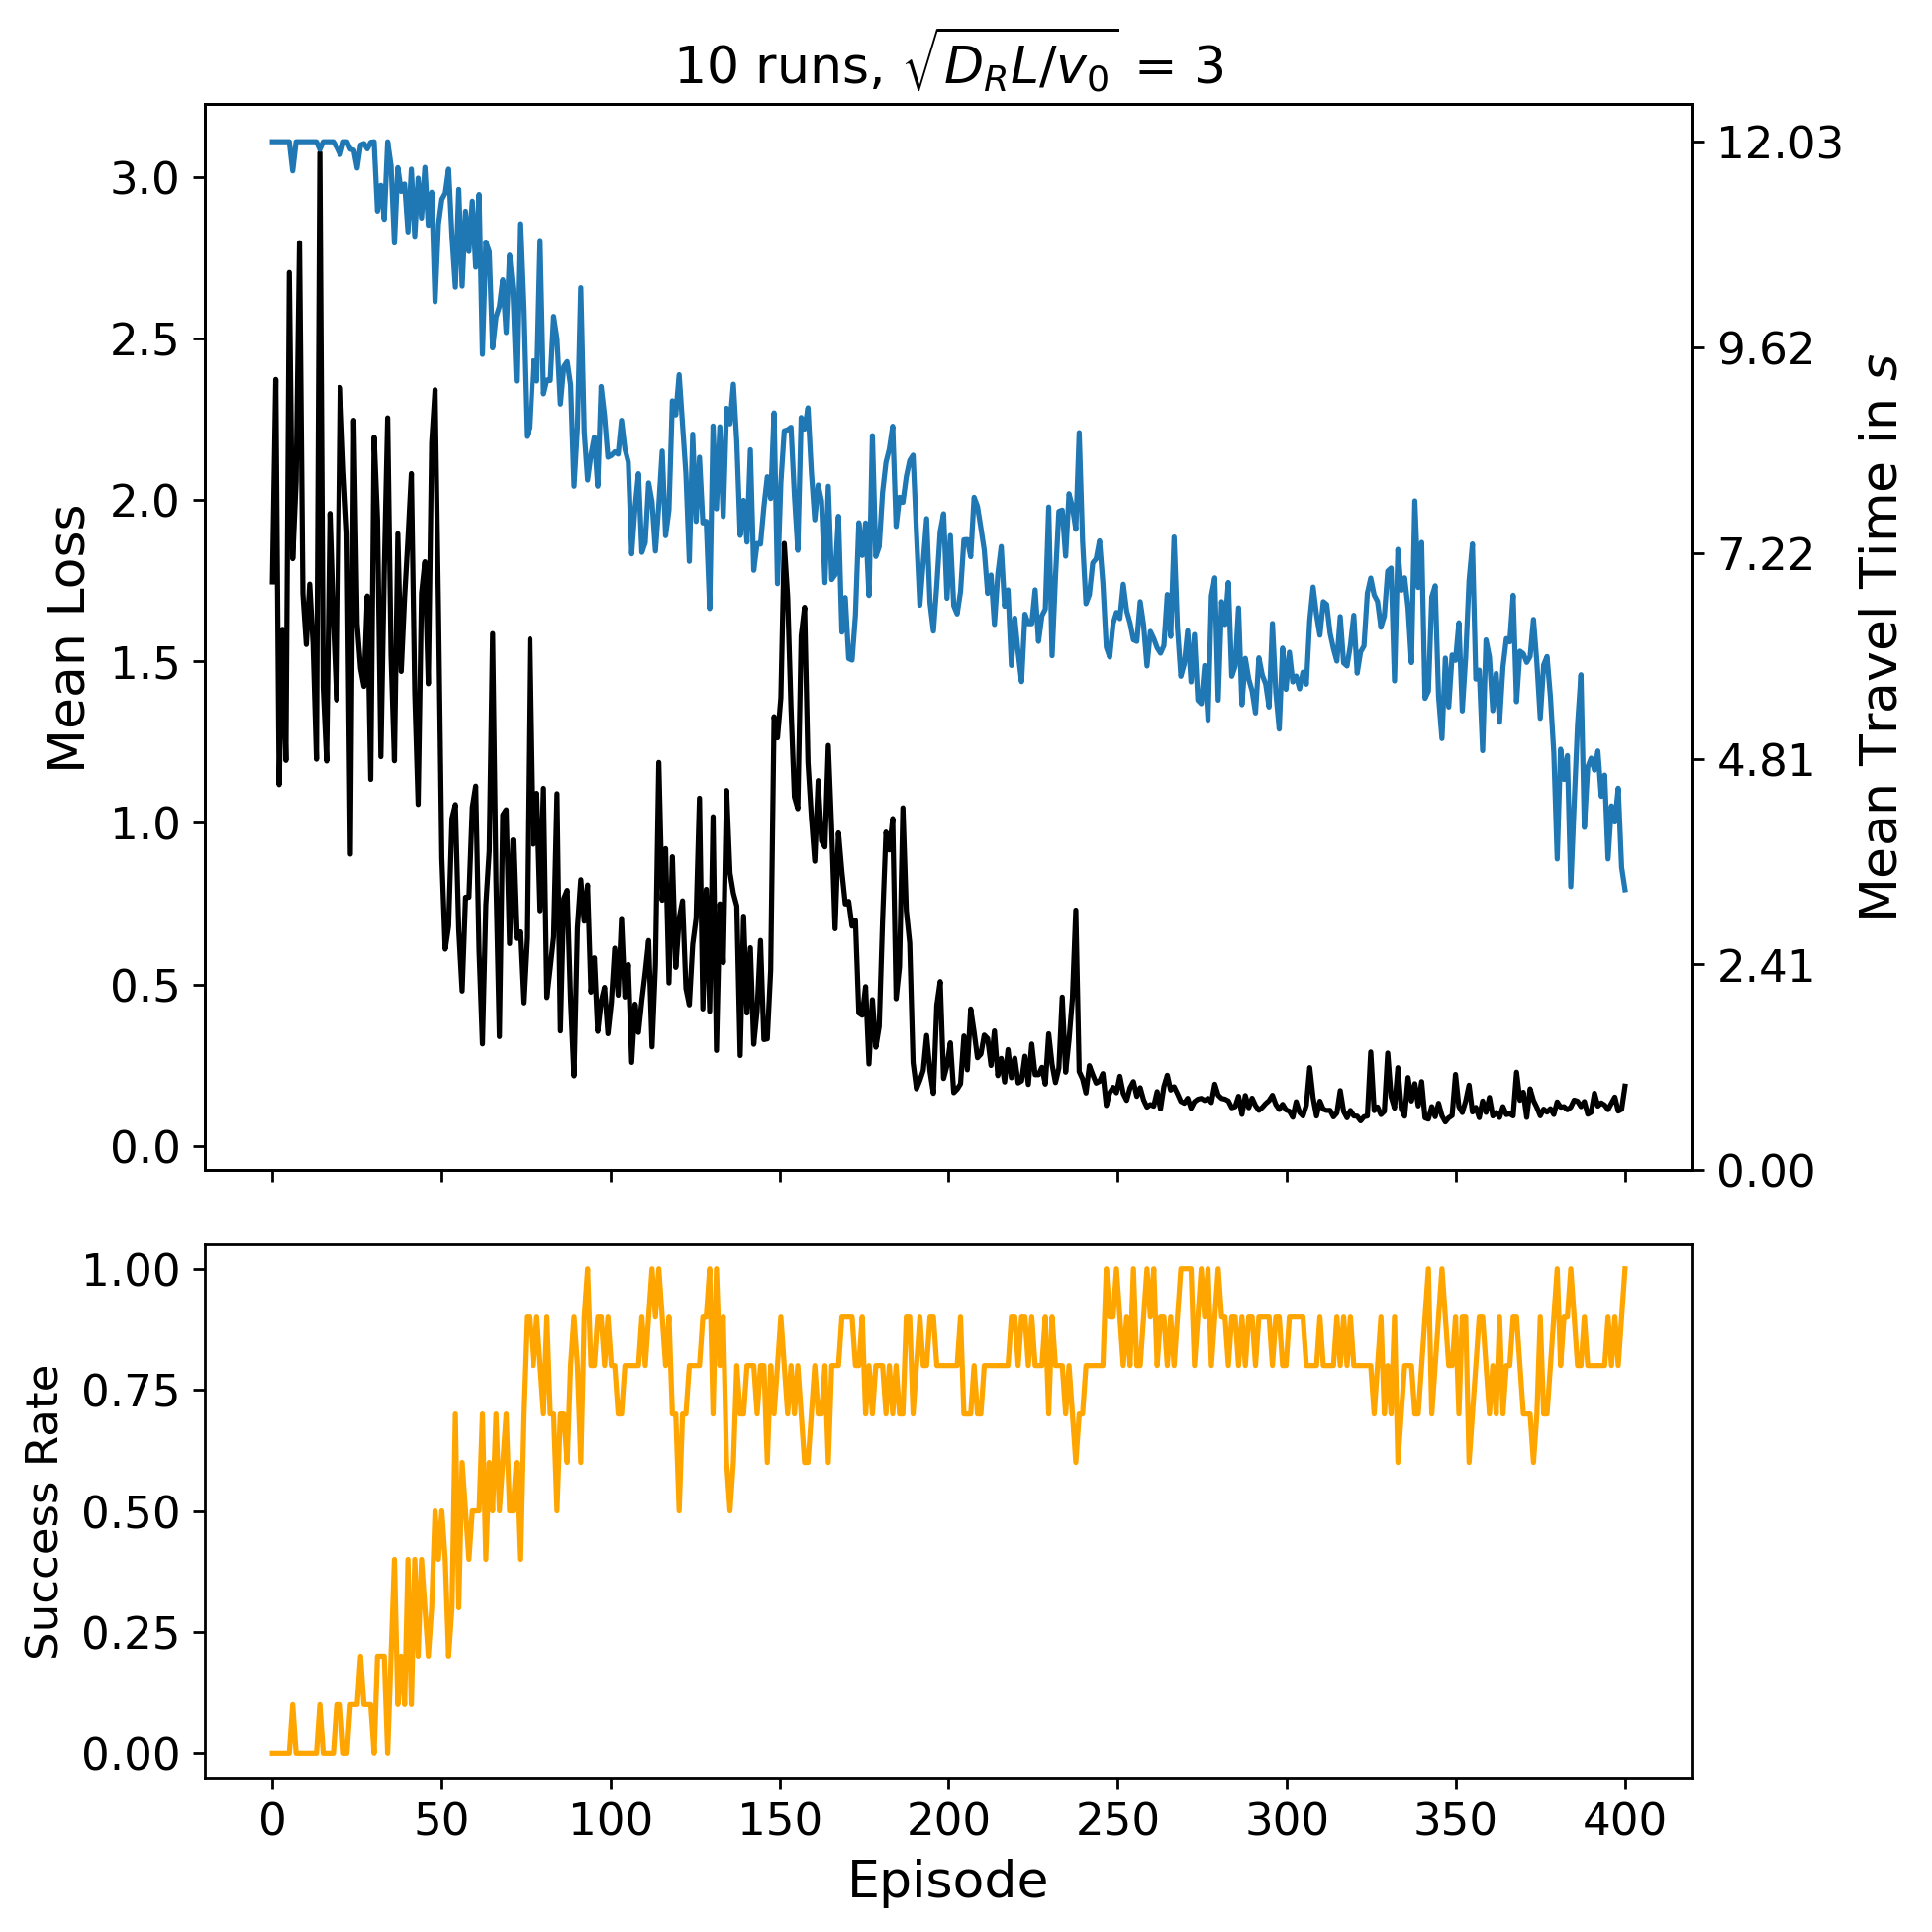

In [ ]:
# print(Loss_total.shape)
fig, (ax1,ax3) = plt.subplots(2,1,sharex=True,figsize=(8,8),height_ratios=[2,1])#dpi=300

ax2 = ax1.twinx()
X = np.linspace(0,epoch,epoch)
yticks = np.round(np.linspace(0,np.max(Runs_avg_time),6),2)
ax1.plot(X,Runs_avg_loss,label = 'Loss', c='black')
ax3.plot(X, Runs_avg_succ, label = 'Success Rate',c='orange')#,marker='.'
ax2.plot(X,Runs_avg_time, label = 'Tavel time')
ax3.set_xlabel('Episode',fontsize=15)
ax1.set_ylabel('Mean Loss',fontsize=15)
ax2.set_ylabel('Mean Travel Time in '+r'$s$',fontsize=15)
ax2.set_yticks(yticks)
ax1.set_title(str(runs) +' runs, ' + r'$\sqrt{D_RL/v_0}$ = '+ str(char_size),fontsize=15)
ax3.set_ylabel('Success Rate')
# fig.legend(bbox_to_anchor=(0.9,0.88))
# ax1.legend(bbox_to_anchor=(1,-0.1))
# ax2.legend(bbox_to_anchor=(1,-0.5))
plt.tight_layout()
plt.show()
# plt.savefig(fname = name, dpi=300)

In [ ]:
# def trained_simulation(agent,epoch, max_steps):
#     agent.eval()
#     episode_paths = []
#     for episode in range(epoch):
#         agent.x = tr.tensor([-0.5],dtype = tr.float).to(device)
#         agent.y =tr.tensor([0],dtype = tr.float).to(device)
#         # X,Y = agent.x,agent.y
#         path = [(agent.x.item(), agent.y.item())]
#         agent.flag = False

#         #episode:
#         for time_step in range(max_steps):
#             F_x,F_y = force(agent.x,agent.y)
#             state = tr.stack([agent.x, agent.y, 
#                         F_x.to(device), F_y.to(device)], dim=1)#,
            
#             with tr.no_grad(): Q1 = agent.forward(state)
#             R = agent.move_reward(Q1,F_x,F_y,0)#only movement is of intereset, epsilon = 0
            
#             # raise Exception(X.shape, Y.shape)
#             # X = tr.cat((X,agent.x))
#             # Y = tr.cat((Y,agent.y))
#             path.append([agent.x.item(),agent.y.item()])

            
#             # if agent.flag: break

#         episode_paths.append(path)
#     return episode_paths

In [ ]:
# episode_paths = trained_simulation(agent,4,100)
# for episode in range(len(episode_paths)):
#     path = episode_paths[episode]
#     print(len(path))
#     x,y = zip(*path)
#     plt.plot(x,y, label = f"Episode {episode+1}" )
# plt.legend()

# plot_potential()
# plt.legend(bbox_to_anchor=(1,-0.1),ncol=2)

# plt.show()
